In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import datetime
from torch.utils.data import DataLoader, Dataset
import torch
sys.path.append(os.path.abspath('../src'))

from data_tools.data_utils import create_data_split



In [2]:
# Set seeds for batch shuffle and during training

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 123
set_seed(seed)

In [3]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40

create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.15,
    test_prop=0.15
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [4]:


complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

val_df = pd.read_csv(project_dir / "data" / "model" / "validation_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
test_df = pd.read_csv(project_dir / "data" / "model" / "test_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

In [5]:
class ReportingDataset(Dataset):
    # first available datapoint is index self.D - 1,
    # e.g D=40, then self.df[39] is first day with a reporting triangle of length 40 

    def __init__(self, df, D, max_val, label_type, device):
        self.D = D
        self.dates = pd.to_datetime(df.copy().index[self.D-1:])
        self.df = np.array(df.copy(), dtype = np.float32)
        self.max_val = max_val
        self.label_type = label_type
        self.device = device

        assert self.label_type in ("y", "z"), 'label_type must either be "y" or "z"'

    def __len__(self):
        return len(self.df) - self.D + 1


    def __getitem__(self, idx):
        t = idx + self.D
        obs = self.df[t-self.D: t]

        # Create observed reporting triangle
        mask = self.get_mask()
        obs_masked = obs.copy() / self.max_val
        obs_masked[~mask] = 0
        obs_masked = torch.tensor(obs_masked, dtype=torch.float32)
        obs_masked = obs_masked.to(self.device)

        # Get day of the week
        date = self.get_date(idx)
        dow = torch.tensor(date.weekday(), dtype=torch.int32)
        dow.to(self.device)
        
        if self.label_type == 'y':
            # Create y label
            y_label = torch.tensor(obs[self.D - 1, :].sum(), dtype=torch.float32)
            y_label.to(self.device)
            return (obs_masked, dow), y_label
        
        elif self.label_type == 'z':
            # Create z label
            z_label = torch.tensor(obs[self.D - 1, :], dtype=torch.float32)
            z_label.to(self.device)
            return (obs_masked, dow), z_label
            
    
    def get_mask(self):
        mask_matrix = np.ones(shape=(self.D, self.D), dtype=bool)
        for i in range(self.D):
            for j in range(self.D):
                if i + j > self.D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

    def get_date(self, idx):
        return self.dates[idx].date()
    
    def get_y(self, idx):
        t = idx + self.D
        return np.array(self.df[t-1].sum())

max_val = train_df.values.max()

Train NowcastPNN model using y directly for benchmark

In [6]:
device = "cpu"

complete_dataset = ReportingDataset(complete_df, 40, max_val, label_type='y', device=device)
train_dataset = ReportingDataset(train_df, 40, max_val, label_type='y', device=device)
val_dataset = ReportingDataset(val_df, 40, max_val, label_type='y', device=device)
test_dataset = ReportingDataset(test_df, 40, max_val, label_type='y', device=device)

In [7]:
####### Potential to add unit tests and asserts here ###########


# Check dataset working as anticipated

# original df
print(train_df.iloc[39].sum())
print(train_df.index[39])

# dataset obj
print(train_dataset.get_y(0))
print(train_dataset.get_date(0))
print(train_dataset.__getitem__(0)[1].sum())

# check mask
train_dataset.__getitem__(0)[0]


4650
2013-03-20
4650.0
2013-03-20
tensor(4650.)


(tensor([[3.6846e-02, 4.8898e-02, 5.3030e-02,  ..., 3.4435e-04, 0.0000e+00,
          0.0000e+00],
         [3.7190e-02, 6.2672e-02, 4.5110e-02,  ..., 3.4435e-04, 3.4435e-04,
          0.0000e+00],
         [4.3733e-02, 6.3361e-02, 6.3361e-02,  ..., 3.4435e-04, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.8216e-01, 3.3643e-01, 2.8512e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.7528e-01, 3.7225e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.9938e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor(2, dtype=torch.int32))

In [7]:
# Create dataloaders, shuffle trainign data for better training
g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
train_dataset.__len__()

1991

In [10]:
train_dataset.__len__()

1991

In [11]:
print(train_dataset.dates)

DatetimeIndex(['2013-03-20', '2013-03-21', '2013-03-22', '2013-03-23',
               '2013-03-24', '2013-03-25', '2013-03-26', '2013-03-27',
               '2013-03-28', '2013-03-29',
               ...
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
               '2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31'],
              dtype='datetime64[ns]', name='Date_Symptoms', length=1991, freq=None)


In [12]:
from PNN.train_utils import train, EarlyStopper
from PNN.NowcastPNN import NowcastPNNDOW

early_stopper = EarlyStopper(patience=30, past_units=40, max_delay=40, weeks=False, future_obs=0, random_split=False, dow = True)
nowcast_pnn = NowcastPNNDOW(past_units=40, max_delay=40, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1], device=device)

train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = device, dow = True)



Epoch 1 - Train loss: 1.98e+05 - Val loss: 2.26e+06 - ES count: 0
Epoch 2 - Train loss: 1.83e+05 - Val loss: 2.06e+06 - ES count: 0
Epoch 3 - Train loss: 1.73e+05 - Val loss: 1.92e+06 - ES count: 0
Epoch 4 - Train loss: 1.63e+05 - Val loss: 1.8e+06 - ES count: 0
Epoch 5 - Train loss: 1.53e+05 - Val loss: 1.63e+06 - ES count: 0
Epoch 6 - Train loss: 1.43e+05 - Val loss: 1.67e+06 - ES count: 1
Epoch 7 - Train loss: 1.32e+05 - Val loss: 1.43e+06 - ES count: 0
Epoch 8 - Train loss: 1.21e+05 - Val loss: 1.47e+06 - ES count: 1
Epoch 9 - Train loss: 1.09e+05 - Val loss: 1.2e+06 - ES count: 0
Epoch 10 - Train loss: 9.73e+04 - Val loss: 9.51e+05 - ES count: 0
Epoch 11 - Train loss: 8.67e+04 - Val loss: 8.7e+05 - ES count: 0
Epoch 12 - Train loss: 7.66e+04 - Val loss: 7.72e+05 - ES count: 0
Epoch 13 - Train loss: 6.68e+04 - Val loss: 6.6e+05 - ES count: 0
Epoch 14 - Train loss: 5.81e+04 - Val loss: 5.97e+05 - ES count: 0
Epoch 15 - Train loss: 5.01e+04 - Val loss: 4.96e+05 - ES count: 0
Epoch 16

In [13]:
## Load best set of weights on test/validation set onto CPU for evaluation
nowcast_pnn = NowcastPNNDOW(past_units=40, max_delay=40, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1], device="cpu")

nowcast_pnn.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / "weights-40-40"))

<All keys matched successfully>

In [6]:
def eval_model(dataset, model, label_type):
    eval_loader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)

    # Put model in eval mode with dropout active
    model.eval()
    model.drop1.train()
    model.drop2.train()

    (matrix, dow), label = next(iter(eval_loader))
    matrix = matrix.to("cpu")
    dow = dow.to("cpu")
    model = model.to("cpu")

    n_samples = 1000
    preds = np.zeros(shape=(dataset.__len__(), n_samples))
    for i in range(n_samples):
        samples = model(matrix, dow).sample().numpy()
        if label_type == 'z':
            samples = samples.sum(axis=-1)
        preds[:, i] = samples

    return preds

def plot_preds(preds, dataset, other_preds=False, other_preds_label=False):
    preds_median = np.quantile(preds, 0.5, axis=1)
    y_true = [dataset.get_y(idx) for idx in range(dataset.__len__())]
    dates = pd.to_datetime(dataset.dates)
    plt.plot(dates, preds_median, label='preds')
    if other_preds is not False:
        plt.plot(dates, other_preds, label=other_preds_label)
    plt.plot(dates, y_true, label='y')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


In [6]:
train_preds = eval_model(train_dataset, nowcast_pnn, label_type='y')
plot_preds(train_preds, train_dataset)


NameError: name 'eval_model' is not defined

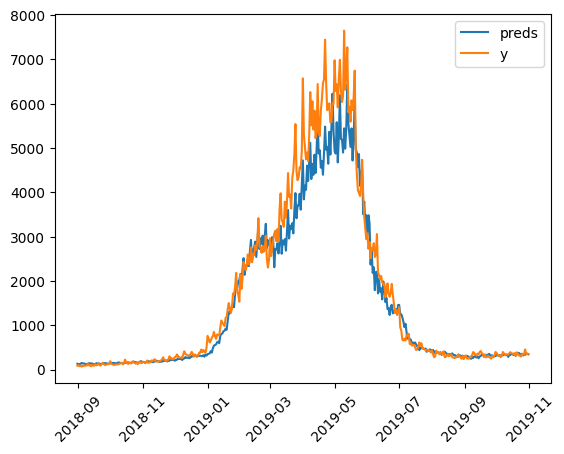

In [16]:
val_preds = eval_model(val_dataset, nowcast_pnn, label_type='y')
plot_preds(val_preds, val_dataset)

In [17]:
print(len(test_dataset))

389


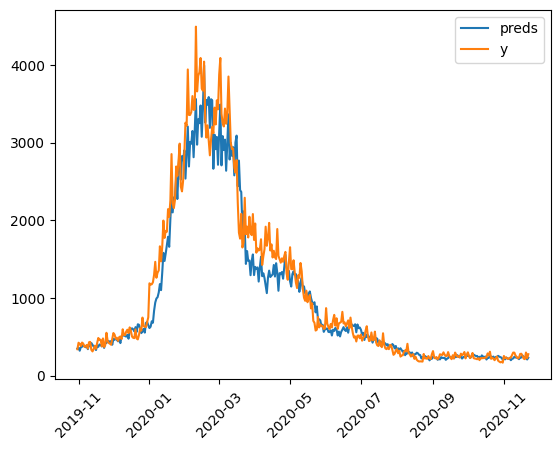

In [18]:
test_preds = eval_model(test_dataset, nowcast_pnn, label_type='y')
plot_preds(test_preds, test_dataset)

Prop PNN 

In [7]:
device = "cpu"

complete_dataset = ReportingDataset(complete_df, 40, max_val, label_type='z', device=device)
train_dataset = ReportingDataset(train_df, 40, max_val, label_type='z', device=device)
val_dataset = ReportingDataset(val_df, 40, max_val, label_type='z', device=device)
test_dataset = ReportingDataset(test_df, 40, max_val, label_type='z', device=device)

# Create dataloaders, shuffle trainign data for better training
g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
from PNN.train_utils import train, EarlyStopper
from PNN.NowcastPNN import PropPNN

early_stopper = EarlyStopper(patience=30, past_units=40, max_delay=40, weeks=False, future_obs=0, random_split=False, dow = True)
prop_pnn = PropPNN(max_val=max_val, past_units=40, max_delay=40, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1], device=device)


In [ ]:
train(prop_pnn, num_epochs=400, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = device, dow = True, label_type='z', alpha=0.5)


Epoch 1 - Train loss: 2.37e+06 - Val loss: 2.43e+07 - ES count: 0
Epoch 2 - Train loss: 1.76e+06 - Val loss: 1.25e+07 - ES count: 0
Epoch 3 - Train loss: 1.54e+06 - Val loss: 1.14e+07 - ES count: 0
Epoch 4 - Train loss: 1.34e+06 - Val loss: 9.54e+06 - ES count: 0
Epoch 5 - Train loss: 1.17e+06 - Val loss: 9.2e+06 - ES count: 0
Epoch 6 - Train loss: 1.16e+06 - Val loss: 8.54e+06 - ES count: 0
Epoch 7 - Train loss: 1.03e+06 - Val loss: 7.34e+06 - ES count: 0
Epoch 8 - Train loss: 9.88e+05 - Val loss: 9.57e+06 - ES count: 1
Epoch 9 - Train loss: 9.24e+05 - Val loss: 6.61e+06 - ES count: 0
Epoch 10 - Train loss: 8.07e+05 - Val loss: 5.56e+06 - ES count: 0
Epoch 11 - Train loss: 7.15e+05 - Val loss: 5.07e+06 - ES count: 0
Epoch 12 - Train loss: 7.49e+05 - Val loss: 4.99e+06 - ES count: 0
Epoch 13 - Train loss: 6.69e+05 - Val loss: 5.59e+06 - ES count: 1
Epoch 14 - Train loss: 6.11e+05 - Val loss: 4.83e+06 - ES count: 0
Epoch 15 - Train loss: 5.98e+05 - Val loss: 4.17e+06 - ES count: 0
Epoch

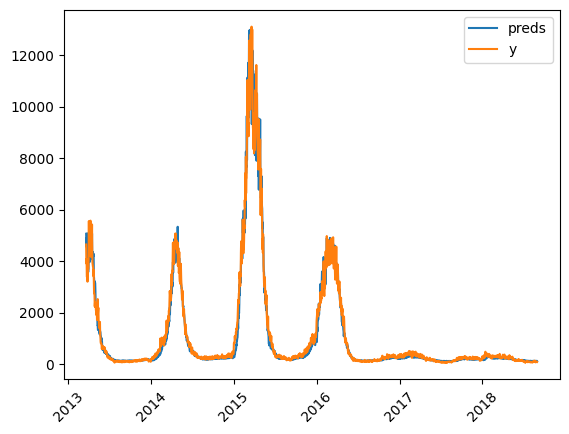

In [10]:
## Load best set of weights on test/validation set onto CPU for evaluation
prop_pnn = PropPNN(max_val=max_val, past_units=40, max_delay=40, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1], device="cpu")

prop_pnn.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / "weights-40-40"))

train_preds_prop = eval_model(train_dataset, prop_pnn, label_type='z')
plot_preds(train_preds_prop, train_dataset)


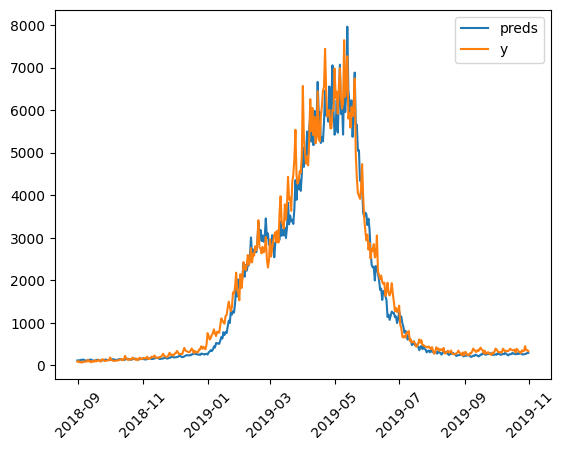

In [11]:
val_preds = eval_model(val_dataset, prop_pnn, label_type='z')
plot_preds(val_preds, val_dataset)


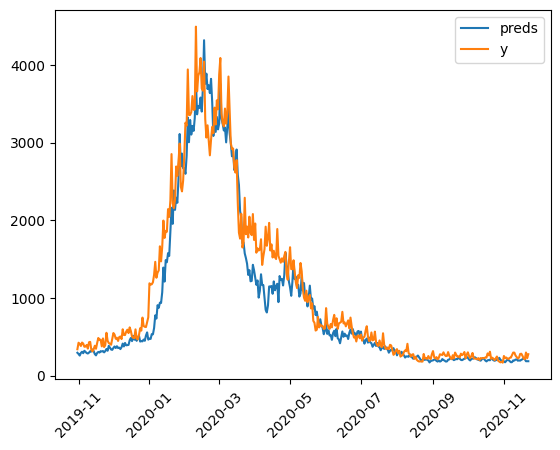

In [12]:
test_preds = eval_model(test_dataset, prop_pnn, label_type='z')
plot_preds(test_preds, test_dataset)